In [1]:
from glob import glob
import numpy as np
import os
from skimage import io
from skimage.transform import resize
import tensorflow as tf
from keras.applications.xception import preprocess_input as xception_preprocess
from keras import layers
from keras.models import Model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns; sns.set()

# Read Dataset

The data has been downloaded from https://www.kaggle.com/ashishjangra27/gender-recognition-200k-images-celeba which consists of 200k images of people's faces classified by gender

The characteristic of this database is that it is standardized by location of the eyes.

This database is structured as follows:

* data
  * Train
     * *.jpg
  * Validation
     * *.jpg
  * Test
     * *.jpg

In [2]:
data_set = ['Train', 'Validation', 'Test']
genders = ['Female', 'Male']

paths = './data/{dataSet}/{gender}*/*.jpg'

partition = {'train':      {'img': [], 'label': []},
             'validation': {'img': [], 'label': []},
             'test':       {'img': [], 'label': []},
             }

for dataSet in data_set:
  for gender in genders:
    for path in glob(paths.format(dataSet=dataSet, gender=gender)):
      partition[dataSet.lower()]['label'].append(gender)
      partition[dataSet.lower()]['img'].append(path)

masks = []
texture = []
for path in glob('./data/masks/*'):
  if os.path.isdir(path):
    for tex in glob(os.path.join(path, '*')):
      texture.append(tex)
  else:
    masks.append(path)

# Data analyst

This database is ideal for research, due to its type of standardization, classification tasks can be accomplished.

Taking advantage of this type of standardization, generalized masks located in the part of the nose and mouth will be used, thus generating a face with a variable mask.

Therefore, the idea is: this database (which is already classified by gender), generate people with a mask and classify them, in addition, different types of masks are generated, modifying the shape, color and texture.

Below you will see an example of the database, without mask generation, of the training set

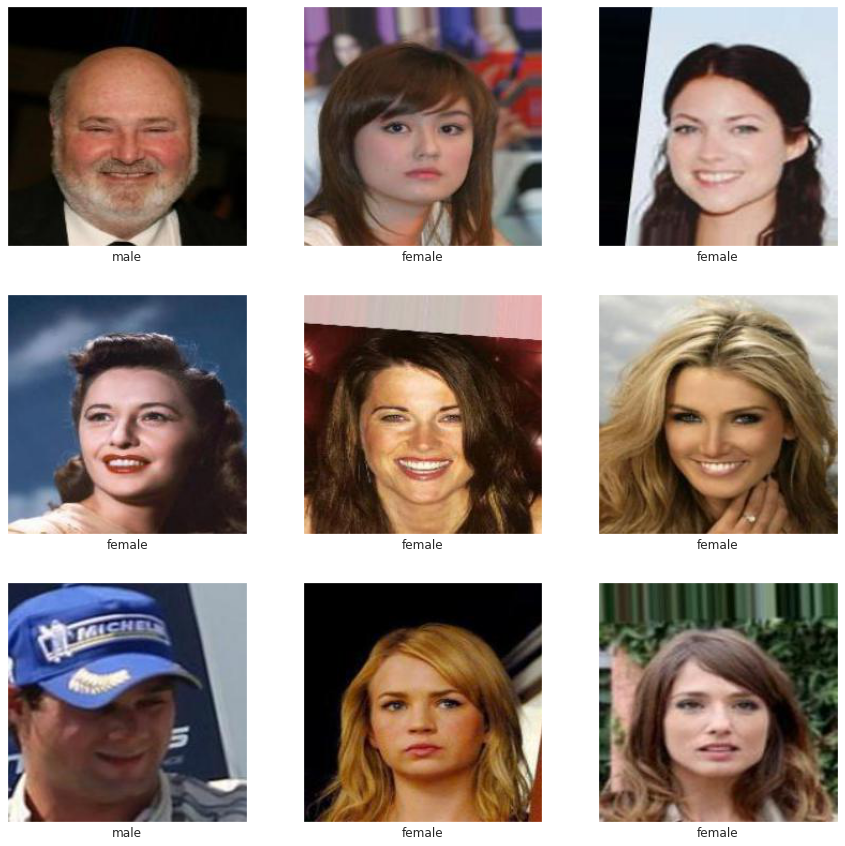

In [3]:
part = partition['train']
np.random.seed(2)
id = np.random.choice(list(range(len(part['img']))), 9, False)
decode = {0: 'male', 1: 'female'}

fig, axes = plt.subplots(3, 3, figsize=[15,15])

for path, label, ax in zip(np.array(part['img'])[id], np.array(part['label'])[id], axes.flat):
  # print(label)
  gender = decode[int(label == 'Female')]

  img = io.imread(path)

  ax.imshow(img)
  ax.set_xlabel(f'{gender}')

  # Remove ticks from the plot.
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

As can be seen in the previous image, the eye on the left (the person's right eye) is always in the same place with subtle differences, so it is proposed to embed a mask in the image, with different shapes and textures .

There are 2 types of masks from which they will be chosen randomly during training.

Demonstration will show the 2 types of masks

## Shape type mask:

This type of mask is obtained from an image of a person with the mask on, the mask is removed only and the image is generated with the mask positioned so that it covers the person's nose and mouth.

Of this type of mask there are 68 images

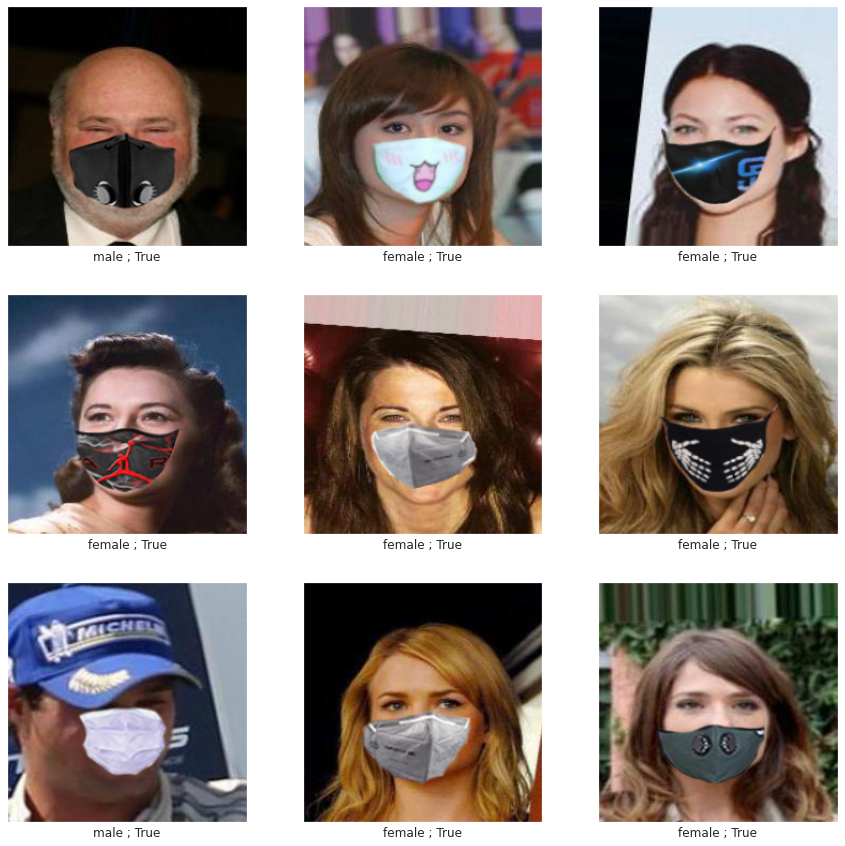

In [4]:
fig, axes = plt.subplots(3, 3, figsize=[15,15])

for path, label, ax in zip(np.array(part['img'])[id], np.array(part['label'])[id], axes.flat):
  gender = decode[int(label == 'Female')]

  img = io.imread(path)

  mask = True

  img_mask = io.imread(np.random.choice(masks))

  img = np.uint8(img * (1 - img_mask[:,:,-1:]/255) + img_mask[:,:,:3] * (img_mask[:,:,-1:]/255))

  ax.imshow(img)
  ax.set_xlabel(f'{gender} ; {mask}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

## Texture type mask:

This type of mask uses the shape of the previous mask, with the difference that the color and texture is replaced by another one extracted from https://www.textures.com This page has different types of textures 510 different textures are used, and in this way, more than 34680 different masks can be generated.

With data augmentation, flip up (50%) and sideways (50%), plus a random cut of the image (the textures have a size greater than the database) it is possible to multiply the previous value by 100 or more , depending on the cut where it is made

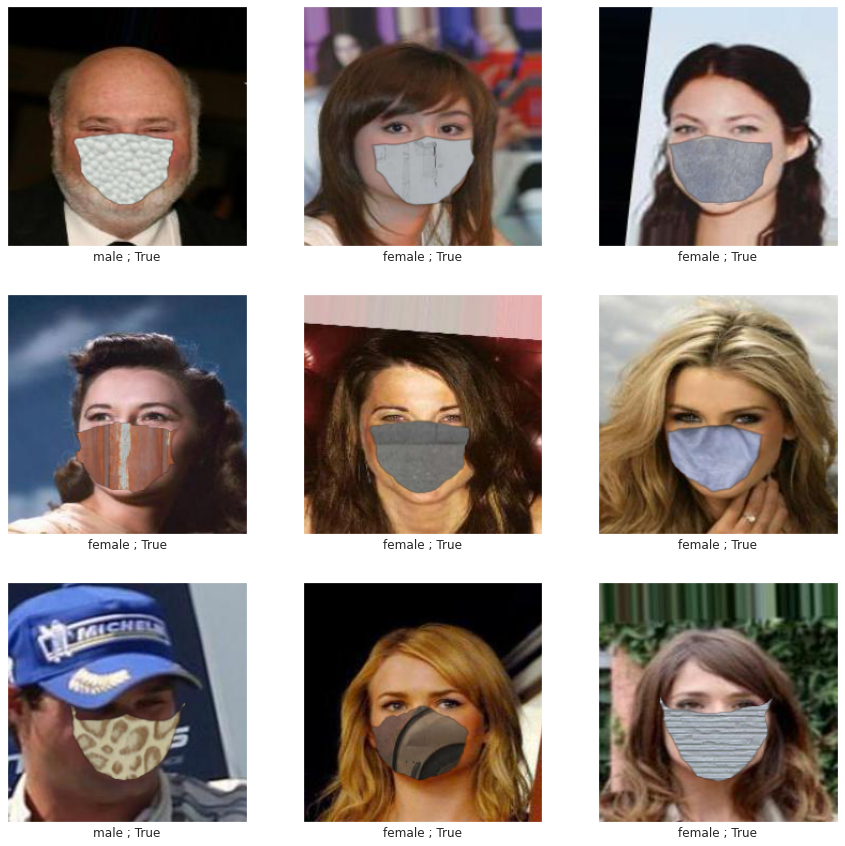

In [5]:
# data augmentation for textures
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq_texture = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Flipud(0.5),
      iaa.CropToFixedSize(width=224, height=224),
    ]
  )

fig, axes = plt.subplots(3, 3, figsize=[15,15])

for path, label, ax in zip(np.array(part['img'])[id], np.array(part['label'])[id], axes.flat):
  gender = decode[int(label == 'Female')]

  img = io.imread(path)

  mask = True

  im_tex = io.imread(np.random.choice(texture))
  im_tex = seq_texture(image=im_tex)
  im_tex = resize(im_tex, [224,224]) * 255
  im_form = io.imread(np.random.choice(masks))

  img_mask = np.zeros_like(im_form)
  img_mask_wo_transparency = (np.float32(im_form[:,:, -1:]) / 255) * np.float32(im_tex)
  img_mask[:,:,:3] = img_mask_wo_transparency
  img_mask[...,-1] = im_form[..., -1]

  img = np.uint8(img * (1 - img_mask[:,:,-1:]/255) + img_mask[:,:,:3] * (img_mask[:,:,-1:]/255))

  ax.imshow(img)
  ax.set_xlabel(f'{gender} ; {mask}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

Putting all of the above together:

The database will have a 50% probability of having a mask

If you have a mask: You will have a 50% probability of choosing between a texture type or a shape type mask

The final images with which the neural network will be trained are shown below, adding the data augmentation to the final image

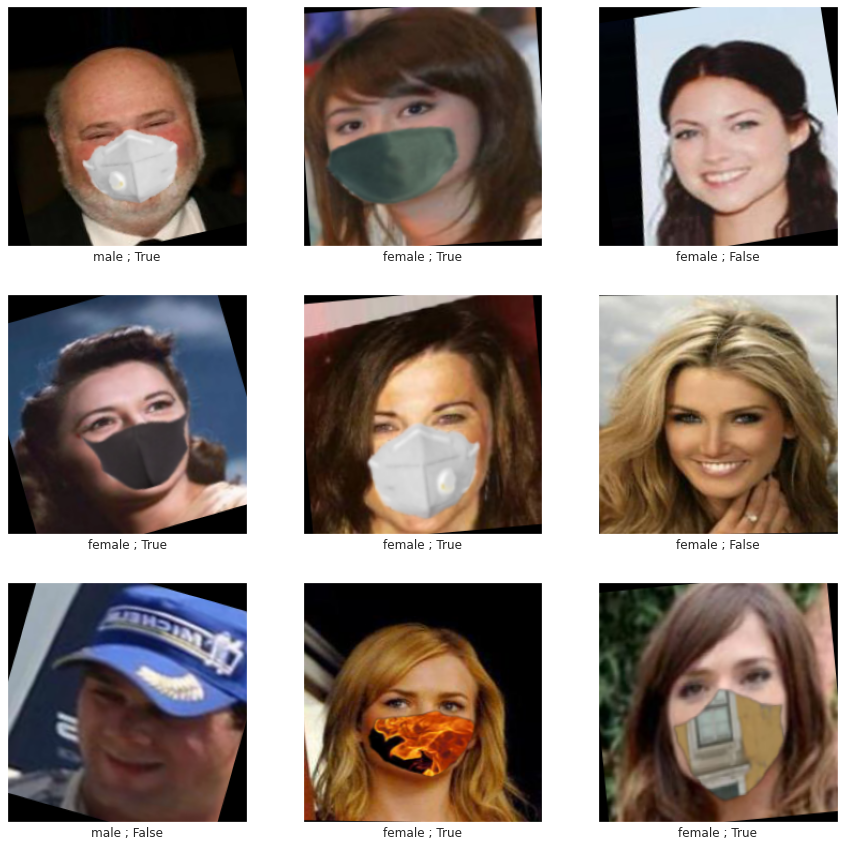

In [6]:
seq_imgs = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Affine(rotate=(-20, 20)),
    ]
  )
fig, axes = plt.subplots(3, 3, figsize=[15,15])

for path, label, ax in zip(np.array(part['img'])[id], np.array(part['label'])[id], axes.flat):
  gender = decode[int(label == 'Female')]

  img = io.imread(path)

  mask = False
  if np.random.randint(2):
    mask = True
    if np.random.randint(2):
      #texture
      im_tex = io.imread(np.random.choice(texture))
      im_tex = seq_texture(image=im_tex)
      im_tex = resize(im_tex, [224,224]) * 255
      im_form = io.imread(np.random.choice(masks))

      img_mask = np.zeros_like(im_form)
      img_mask_wo_transparency = (np.float32(im_form[:,:, -1:]) / 255) * np.float32(im_tex)
      img_mask[:,:,:3] = img_mask_wo_transparency
      img_mask[...,-1] = im_form[..., -1]

    else:
      img_mask = io.imread(np.random.choice(masks))

    img = img * (1 - img_mask[:,:,-1:]/255) + img_mask[:,:,:3] * (img_mask[:,:,-1:]/255)

  img = np.uint8(img)
  img = np.uint8(resize(img, (224, 224)) * 255)
  img = seq_imgs(image=img)

  ax.imshow(img)
  ax.set_xlabel(f'{gender} ; {mask}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Model

The defined model is an adaptation of the Xception model.

In [7]:
function_none = lambda x: x
function_one_hot = lambda x: to_categorical(x, 2)
function_inverse_one_hot = lambda x: np.argmax(x, axis=-1)
inverse_functions = {function_none: function_none,
                    function_one_hot: function_inverse_one_hot}

def model_optimized():
  inputs = layers.Input((None, None, 3))
  x = layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv1_pad')(inputs)
  x = layers.Conv2D(32, (3, 3), padding='valid', use_bias=False, strides=(2, 2), name='conv1')(x)
  x = layers.BatchNormalization(name='conv1_bn')(x)
  x = layers.ReLU(10., name='conv1_relu')(x)

  id = 0
  id += 1
  x = layers.SeparableConv2D(64, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(128, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(128, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(256, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(256, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)


  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  mask = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(mask)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(1024, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(1024, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  gender = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  mask = layers.GlobalAvgPool2D()(mask)
  gender = layers.GlobalAvgPool2D()(gender)

  mask = layers.Dropout(0.3)(mask)
  gender = layers.Dropout(0.3)(gender)

  mask = layers.Dense(1, activation='sigmoid', name='mask')(mask)
  gender = layers.Dense(1, activation='sigmoid', name='gender')(gender)

  model = Model(inputs=inputs, outputs=[gender, mask], name='optimized')

  model.compile('adam', {'gender': 'binary_crossentropy',
                         'mask': 'binary_crossentropy'},
                metrics=['acc'])

  return model, xception_preprocess, function_none
#   return model, function_none, function_none


models = {'optimized': model_optimized}

# Generators

Being a problem with a lot of data, and with the proposal to generate images in real time, a generator that feeds the network is necessary.

This generator returns images every time it is called

In [8]:
# data augmentation
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq_texture = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Flipud(0.5),
      iaa.CropToFixedSize(width=224, height=224),
    ]
  )

seq_imgs = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Affine(rotate=(-20, 20)),
    ]
  )

class Generator(Sequence):
  def __init__(self, part, batchSize:int=4, data_set='train', preprocess=None,
               label_encoded=None):
    if data_set == 'train':
      assert label_encoded != None
      assert preprocess != None
    self.part = part
    self.part['img'] = np.array(part['img'])
    self.part['label'] = np.array(part['label'])
    self.data_set = data_set
    self.batch_size = batchSize

    self.on_epoch_end()

    self.label_encoded = label_encoded
    self.preprocess = preprocess

  def on_epoch_end(self):
    List = np.array(list(range(int(len(self.part['img'])))))
    np.random.shuffle(List)
    out_list = []
    l = []
    for lis in List:
      if len(l) == self.batch_size:
        out_list.append(l)
        l = []
      l.append(lis)
    if len(l) > 0:
      out_list.append(l)
    self.list = np.array(out_list)

  def __len__(self):
    return len(self.list)

  def __getitem__(self, index):
    id = self.list[index]

    imgs = []
    labels = {'gender': [], 'mask': []}
    for path, label in zip(self.part['img'][id], self.part['label'][id]):
      gender = int(label == 'Female')

      img = io.imread(path)

      mask = 0
      if np.random.randint(2):
        mask = 1
        if np.random.randint(2):
          #texture
          im_tex = io.imread(np.random.choice(texture))
          im_tex = seq_texture(image=im_tex)
          im_tex = resize(im_tex, [224,224]) * 255
          im_form = io.imread(np.random.choice(masks))

          img_mask = np.zeros_like(im_form)
          img_mask_wo_transparency = (np.float32(im_form[..., -1:]) / 255) * np.float32(im_tex)
          img_mask[:,:,:3] = img_mask_wo_transparency
          img_mask[...,-1] = im_form[..., -1]

        else:
          img_mask = io.imread(np.random.choice(masks))

        img = img * (1 - img_mask[:,:,-1:]/255) + img_mask[...,:3] * (img_mask[:,:,-1:]/255)

      img = np.uint8(img)
      img = np.uint8(resize(img, (224, 224)) * 255)
      imgs.append(img)
      labels['gender'].append(gender)
      labels['mask'].append(mask)
    imgs = np.array(imgs)
    if self.data_set == 'train':
      imgs = seq_imgs(images=imgs)
    labels['gender'] = np.array(labels['gender'])
    labels['mask'] = np.array(labels['mask'])
    if self.data_set == 'train':
      imgs = self.preprocess(imgs)
      labels['gender'] = self.label_encoded(labels['gender'])
      labels['mask']   = self.label_encoded(labels['mask'])
    return imgs, labels

# Functions helpers

These functions help the code look more organized

In [9]:
def plot_history(history, title):

    losses = list(np.copy(history.history['loss']))
    # accs = list(np.copy(history.history['acc']))
    hue = ['train'] * len(history.history['loss'])

    losses.extend(history.history['val_loss'])
    # accs.extend(history.history['val_acc'])
    hue.extend(['val'] * len(history.history['val_loss']))

    epoch = list(np.copy(history.epoch))
    epoch.extend(history.epoch)

    to_plot = pd.DataFrame(dict(
    epochs=epoch,
    losses=losses,
    dataset=hue,
    ))

    losses = list(np.copy(history.history['gender_loss']))
    hue = ['gender train loss'] * len(history.history['loss'])
    epoch = list(np.copy(history.epoch))

    losses.extend(list(np.copy(history.history['mask_loss'])))
    hue.extend(['mask train  loss'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    losses.extend(list(np.copy(history.history['val_gender_loss'])))
    hue.extend(['gender val  loss'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    losses.extend(list(np.copy(history.history['val_mask_loss'])))
    hue.extend(['mask val  loss'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    to_plot_loss_class = pd.DataFrame(dict(
    epochs=epoch,
    losses=losses,
    dataset=hue
    ))

    acc = list(np.copy(history.history['gender_acc']))
    hue = ['gender train acc'] * len(history.history['loss'])
    epoch = list(np.copy(history.epoch))

    acc.extend(list(np.copy(history.history['mask_acc'])))
    hue.extend(['mask train acc'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    acc.extend(list(np.copy(history.history['val_gender_acc'])))
    hue.extend(['gender val acc'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    acc.extend(list(np.copy(history.history['val_mask_acc'])))
    hue.extend(['mask val acc'] * len(history.history['loss']))
    epoch.extend(list(np.copy(history.epoch)))

    to_plot_acc = pd.DataFrame(dict(
    epochs=epoch,
    accuracy=acc,
    dataset=hue
    ))

    ax = sns.relplot(x="epochs", y="losses", hue="dataset", kind="line",
                   ci="sd", data=to_plot)
    ax.set(title=title)
    plt.show()

    ax = sns.relplot(x="epochs", y="losses", hue="dataset", kind="line",
                   ci="sd", data=to_plot_loss_class)
    ax.set(title=title)
    plt.show()

    ax = sns.relplot(x="epochs", y="accuracy", hue="dataset", kind="line",
                   ci="sd", data=to_plot_acc)
    ax.set(title=title)
    plt.show()

# Training

Static validation is generated, it is created once and is the same for all networks and trainings

Then you start training the networks and capture the results to show them later

optimized
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
625/625 [==============================] - ETA: 0s - loss: 0.8279 - gender_loss: 0.5785 - mask_loss: 0.2494 - gender_acc: 0.6929 - mask_acc: 0.9003
Epoch 00001: val_loss improved from inf to 0.58538, saving model to ./models/model_optimized_E60_B16.h5
625/625 [==============================] - 174s 279ms/step - loss: 0.8279 - gender_loss: 0.5785 - mask_loss: 0.2494 - gender_acc: 0.6929 - mask_acc: 0.9003 - val_loss: 0.5854 - val_gender_loss: 0.4646 - val_mask_loss: 0.1208 - val_gender_acc: 0.7670 - val_mask_acc: 0.9600
Epoch 2/60
625/625 [==============================] - ETA: 0s - loss: 0.5277 - gender_loss: 0.4167 - mask_loss: 0.1111 - gender_acc: 0.8092 - mask_acc: 0.9608
Epoch 00002: val_loss improved from 0.58538 to 0.35984, saving model to ./models/model_optimized_E60_B16.h5
625/625 [==============================] - 157s 251ms/step - loss: 0.5277 - gender_loss: 0.4167 - mask_loss: 0.

625/625 [==============================] - 232s 370ms/step - loss: 0.1436 - gender_loss: 0.1308 - mask_loss: 0.0128 - gender_acc: 0.9510 - mask_acc: 0.9959 - val_loss: 0.1148 - val_gender_loss: 0.1129 - val_mask_loss: 0.0019 - val_gender_acc: 0.9580 - val_mask_acc: 0.9990
Epoch 17/60
625/625 [==============================] - ETA: 0s - loss: 0.1349 - gender_loss: 0.1227 - mask_loss: 0.0122 - gender_acc: 0.9545 - mask_acc: 0.9963
Epoch 00017: val_loss did not improve from 0.11480
625/625 [==============================] - 227s 363ms/step - loss: 0.1349 - gender_loss: 0.1227 - mask_loss: 0.0122 - gender_acc: 0.9545 - mask_acc: 0.9963 - val_loss: 0.1325 - val_gender_loss: 0.1250 - val_mask_loss: 0.0075 - val_gender_acc: 0.9530 - val_mask_acc: 0.9970
Epoch 18/60
625/625 [==============================] - ETA: 0s - loss: 0.1328 - gender_loss: 0.1211 - mask_loss: 0.0118 - gender_acc: 0.9539 - mask_acc: 0.9962
Epoch 00018: val_loss did not improve from 0.11480
625/625 [=======================

Epoch 50/60
625/625 [==============================] - ETA: 0s - loss: 0.0638 - gender_loss: 0.0611 - mask_loss: 0.0027 - gender_acc: 0.9767 - mask_acc: 0.9989
Epoch 00050: val_loss did not improve from 0.07560
625/625 [==============================] - 142s 228ms/step - loss: 0.0638 - gender_loss: 0.0611 - mask_loss: 0.0027 - gender_acc: 0.9767 - mask_acc: 0.9989 - val_loss: 0.1166 - val_gender_loss: 0.1159 - val_mask_loss: 6.8221e-04 - val_gender_acc: 0.9620 - val_mask_acc: 1.0000
Epoch 51/60
625/625 [==============================] - ETA: 0s - loss: 0.0690 - gender_loss: 0.0658 - mask_loss: 0.0033 - gender_acc: 0.9749 - mask_acc: 0.9990
Epoch 00051: val_loss did not improve from 0.07560
625/625 [==============================] - 149s 239ms/step - loss: 0.0690 - gender_loss: 0.0658 - mask_loss: 0.0033 - gender_acc: 0.9749 - mask_acc: 0.9990 - val_loss: 0.1384 - val_gender_loss: 0.1176 - val_mask_loss: 0.0208 - val_gender_acc: 0.9510 - val_mask_acc: 0.9950
Epoch 52/60
625/625 [=======

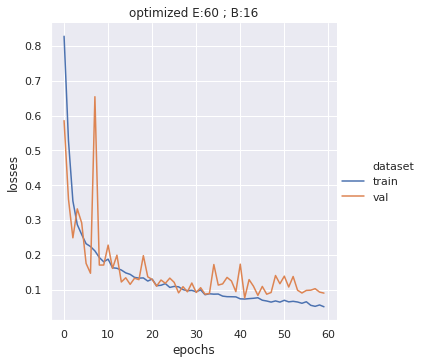

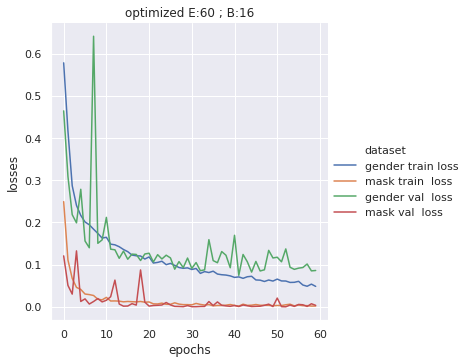

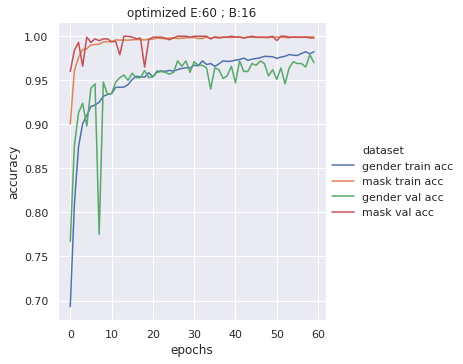

In [10]:
# Static validation generation for all models and trainings
val   = Generator(partition['validation'],
                  batchSize=len(partition['validation']['img']), data_set='val')
# static or dynamic validation
imgs_val, labels_val = val[0]

if not os.path.exists('./models'):
    os.mkdir('./models')

models_save = {}

for name_model, model_function in models.items():
    print(name_model)

    epochs = [60]

    for epoch in epochs:
            batch = 16
            K.clear_session()
            model, preprocess, function_label = model_function()
            # Dynamic training generation
            train = Generator(partition['train'], batchSize=batch, preprocess=preprocess,
                            label_encoded=function_label)
            
            
            img_val_for_model = preprocess(np.copy(imgs_val))
            
            labels_val_for_model = {}
            labels_val_for_model['gender'] = function_label(np.copy(labels_val['gender']))
            labels_val_for_model['mask'] = function_label(np.copy(labels_val['mask']))

            filename_best_model = './models/model_{}_E{}_B{}.h5'.format(name_model, epoch, batch)
            callbacks = [ModelCheckpoint(filename_best_model, save_best_only=True, verbose=1)]
            history = model.fit_generator(generator=train, epochs=epoch, verbose=1,
                                        validation_data=(img_val_for_model, labels_val_for_model), shuffle=True,
                                        callbacks=callbacks,
                                        )
            plot_history(history, '{} E:{} ; B:{}'.format(name_model, epoch, batch))
            models_save[name_model] = filename_best_model

K.clear_session()